## Overview

In [1]:
%pylab inline
%cd lib
!python3 setup.py build_ext --inplace

Populating the interactive namespace from numpy and matplotlib
/workspace/1D/lib
Compiling Pgaussinterpolation.pyx because it changed.
[1/1] Cythonizing Pgaussinterpolation.pyx
/usr/lib/python3/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /workspace/1D/lib/Pgaussinterpolation.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'Pgaussinterpolation' extension
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.8 -c Pgaussinterpolation.c -o build/temp.linux-x86_64-3.8/Pgaussinterpolation.o
In file included from /usr/include/python3.8/numpy/ndarraytypes.h:1830,
                 from /usr/include/python3

x86_64-linux-gnu-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fwrapv -O2 -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fwrapv -O2 -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 build/temp.linux-x86_64-3.8/Pgaussinterpolation.o -o /workspace/1D/lib/Pgaussinterpolation.cpython-38-x86_64-linux-gnu.so


In [2]:
import sys
sys.path.append('../lib/')
import QMbasics as QM
#importing all different implementations
from Ppolyinterpolation import Ppolyinterpolation,Phalfstep_polyinterpolation
from Pgaussinterpolation import Pgaussinterpolation
from Pgaussnearestneighbour import Pgaussnearestneighbour
from MIWorig import MIWorig

In [3]:
n=1
N=22
#worlds = linspace(-2.5,2.5,N)
worlds = QM.get_harmonic_worlds(n,N,half_sized_tails=True)
filter_indices = np.ones_like(worlds,dtype=np.int)
filter_indices[N//2-1:N//2+1]=0

#worlds = linspace(-4,4,N)
state = QM.HarmonicStationaryState(n)
groundstate = QM.HarmonicStationaryState(0)
phase = np.array(np.sign(state.psi_(worlds)),dtype=np.int)
algorithms = {}
algorithms["MIW toy model"] = MIWorig(worlds,phase=phase,filter_indices=filter_indices)
algorithms["Gaussinterpolation"] = Pgaussinterpolation(worlds,phase=phase,recursive_interpolation=30)
algorithms["Adaptive kernel $h_i=\sqrt{\mathrm{nndist}_i}$"] = Pgaussnearestneighbour(worlds,phase=phase)


1
1


### density profile before groundstate algorithm

In [4]:
x = linspace(-4.,4.,1000)

Intial pdata:

In [5]:
pinitialx = {key: alg.p_eval_vec(x) for (key,alg) in algorithms.items()}
pinitialworlds = {key: alg.p_eval_vec(worlds) for (key,alg) in algorithms.items()}
worldsinitial = worlds.copy()

Carrying out the algorithm:

In [6]:
dt =7e-3
NumIterations=100000
OutputEvery=1000
result = {}
for i,alg in algorithms.items():
    print(i)
    result[i]=alg.update(dt=dt, NumIterations=NumIterations,
                         OutputEvery=OutputEvery,check_crossing=True)

MIW toy model
0%  10%  20%  30%  40%  50%  60%  70%  80%  90%  100%
Gaussinterpolation
0%  10%  20%  30%  40%  50%  60%  70%  80%  90%  100%
Adaptive kernel $h_i=\sqrt{\mathrm{nndist}_i}$
0%  10%  20%  30%  40%  50%  60%  70%  80%  90%  100%


In [7]:
pfinalx = {key: alg.p_eval_vec(x) for (key,alg) in algorithms.items()}
pfinalworlds = {key: alg.p_eval_vec(alg.worlds) for (key,alg) in algorithms.items()}
worldsfinal = {key: alg.worlds for (key,alg) in algorithms.items()}

Plotting results:

In [8]:
keys = list(algorithms.keys())

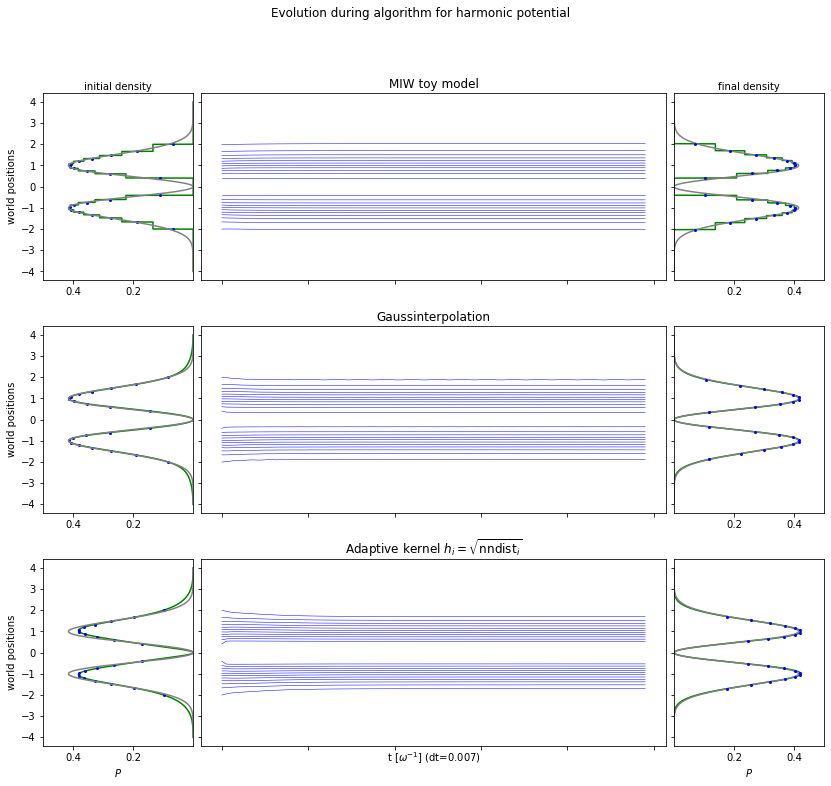

In [9]:
keys = list(algorithms.keys())
nalgs = len(algorithms)
import matplotlib.gridspec as gridspec
fig = figure(figsize=(14,4*nalgs))
fig.suptitle("Evolution during algorithm for harmonic potential")
gs = gridspec.GridSpec(nalgs,5,wspace=0.05,hspace=0.25)
axes = {}
rows = {}
for i in range(nalgs):
    if i==0:
        axm = plt.subplot(gs[i,1:-1])
    else:
        axm = plt.subplot(gs[i,1:-1],sharex=axm)
    axl = plt.subplot(gs[i,0],sharey=axm)
    axr = plt.subplot(gs[i,-1],sharey=axm)
    axes[keys[i]] = axl, axm, axr
    rows[keys[i]] = i

def plot_key(key):

    axpfromworlds, ax, axpfromworldsend  = axes[key]
    res=result[key]
    #fig = figure(figsize=(7,4.5))
    #fig.suptitle("Groundstatealgorithm for harmonic potential with $N=40$ worlds")
    #ax = fig.add_subplot(111)
    ax.set_title(key)
    ax.plot(res[1],res[0],color='blue',lw=0.5);
    plt.style.use({"lines.markersize":2})

    #ax.set_ylabel('worlds N={}'.format(N))

    axorig=ax
    plt.setp(axpfromworldsend.get_yticklabels()+axorig.get_yticklabels() +axorig.get_xticklabels(),
            visible=False)


    axpfromworlds.plot( pinitialx[key],x,color='green',label="density\nestimate")
    axpfromworlds.plot(pinitialworlds[key],worldsinitial,"o",color='blue', label="worlds")
    #axpfromworlds.legend(loc="upper left",fontsize=8)

    #axpfromworlds.plot(groundstate.p_(x),x,"--",color='gray')
    #axpfromworlds.plot(state.p_(x),x,"--",color='gray')

    axpfromworlds.set_xlim(0,0.5)
    axpfromworlds.set_ylabel('world positions'.format(N))
    axpfromworlds.plot(state.p_(x),x,"-",color='gray', label="exact\ngroundstate")

    axpfromworlds.invert_xaxis()
    axpfromworlds.set_xticks([0.2,0.4])

    axpfromworldsend.plot(pfinalx[key],x,color='green')
    axpfromworldsend.plot(state.p_(x),x,"-",color='gray', label="exact\ngroundstate")
    axpfromworldsend.plot(pfinalworlds[key],worldsfinal[key],"o",color='blue')
    #axpfromworldsend.legend(loc='upper right',fontsize=8)
    axpfromworldsend.set_xlim(0,0.5)


    axpfromworldsend.set_xticks([0.2,0.4])

    if rows[key] == 0:
        axpfromworlds.xaxis.set_label_position('top')
        axpfromworldsend.xaxis.set_label_position('top') 

        axpfromworlds.set_xlabel("initial density")
        axpfromworldsend.set_xlabel("final density")
    if rows[key] == nalgs-1:
        axpfromworlds.set_xlabel("$P$")
        axpfromworldsend.set_xlabel("$P$")
        plt.setp(ax.get_xticklabels(),visible=True)
        ax.set_xlabel('t [$\omega^{-1}$]'+' (dt={})'.format(dt))


for key in keys:
    plot_key(key)



Text(0.5, 1.0, 'Relative error')

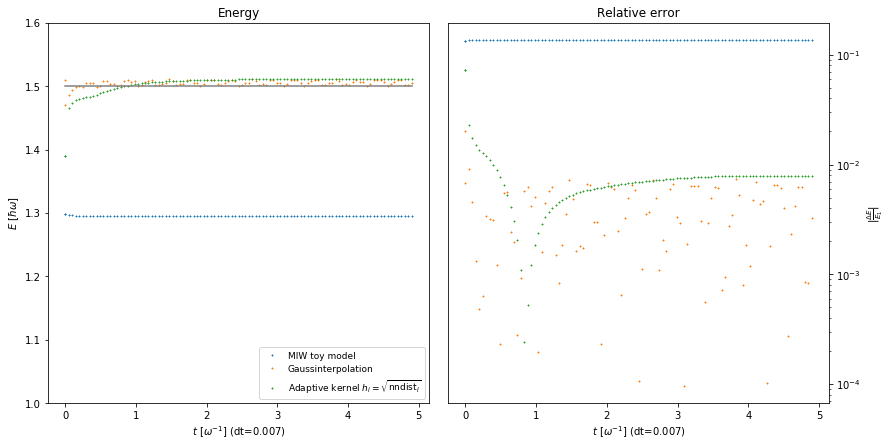

In [10]:
fig = figure(figsize=(14,7))
gs = gridspec.GridSpec(1,2,wspace=0.05)
ax = [plt.subplot(gs[0]),plt.subplot(gs[1])]

ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

plt.sca(ax[0])
for key in keys:
    plot(result[key][1],result[key][2],"+",label=key)
plot(result[key][1],np.ones_like(result[key][1])*1.5,"-",color="grey")
ylim(1.,1.6)
title("Energy")
xlabel('$t$ [$\omega^{-1}$]'+' (dt={})'.format(dt))
ylabel('$E$ [$\hbar \omega$]')
legend(fontsize=9,loc="lower right")

plt.sca(ax[1])

for key in keys:
    plot(result[key][1],np.abs(result[key][2]-1.5)/1.5,"+",label=key)
xlabel(r'$t$ [$\omega^{-1}$]'+' (dt={})'.format(dt))
ylabel(r'$\left|\frac{\Delta E}{E_1}\right|$ ',)
yscale('log')
title("Relative error")



Text(0, 0.5, 'density')

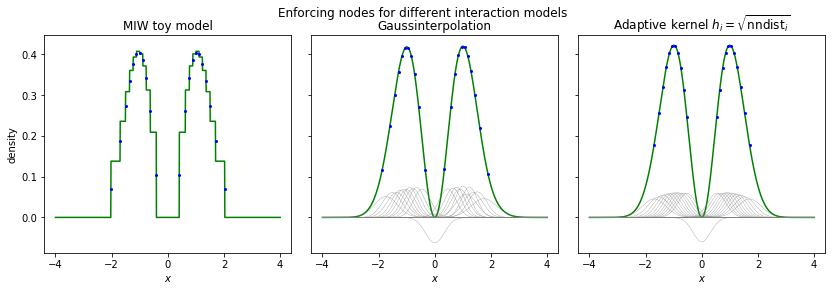

In [12]:
fig = figure(figsize=(14,4))
fig.suptitle("Enforcing nodes for different interaction models")
gs = gridspec.GridSpec(1,3,wspace=0.08)
axl = plt.subplot(gs[0])
axm = plt.subplot(gs[1],sharey=axl)
axr = plt.subplot(gs[2],sharey=axl)

keys.sort()
key = keys[0]
alg = algorithms[key]
ax = axr
ax.set_title(key)
ax.plot(x, alg.p_eval_vec(x),color='green')
ax.plot(alg.worlds, alg.p_eval_vec(alg.worlds),"o",color='blue')
ax.set_xlabel("$x$")

for k in alg.get_all_K(x):
    ax.plot(x,k,color='gray',lw=0.3)

key = keys[1]
alg = algorithms[key]
ax = axm
ax.set_title(key)
ax.plot(x, alg.p_eval_vec(x),color='green')
ax.plot(alg.worlds, alg.p_eval_vec(alg.worlds),"o",color='blue')
for k in alg.get_all_K(x):
    ax.plot(x,k,color='gray',lw=0.3)
ax.set_xlabel("$x$")

key = keys[2]
alg = algorithms[key]
ax = axl
ax.set_title(key)
ax.plot(x, alg.p_eval_vec(x),color='green')
ax.plot(alg.worlds, alg.p_eval_vec(alg.worlds),"o",color='blue')
ax.set_xlabel("$x$")

plt.setp(axm.yaxis.get_ticklabels()+axr.yaxis.get_ticklabels(),visible=False);
axl.set_ylabel("density")

